In [1]:
#import
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

In [2]:
#binaryデータを開く関数
def open_grd(gpv_file):
  with open(gpv_file, 'rb') as ifile:
#    data = np.fromfile(ifile, dtype='f4', sep = '')
    data = np.fromfile(ifile, dtype='f8', sep = '')
  return data

In [3]:
#parameter
#phase = ['uinfdown','uinfup','umax','umin']
phase1 = 'vinfdown'
phase2 = 'vinfup'
phase3 = 'vmax'
phase4 = 'vmin'
phase = [phase1,phase2,phase3,phase4]
num_class = len(phase)
flow = ['400','450','500']
file_num1=6
file_num2=12
nx=191
ny=98
nz=10
file_num = num_class*(file_num1*2+file_num2)
test_size = 0.1

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#fileの読み込み(位相平均データ)
data_root = '/content/drive/My Drive/機械学習/燃焼振動/velophasemeanfield_calc/'
data_origin = np.zeros((file_num,nz,nx,ny))
phase_num = np.zeros((file_num*nz,num_class))
nf = 0
for ph in phase:
    for fl in flow:
        if fl=='450':
            for n in range(file_num2):
                data_name = 'phasemean_'+ph+'_'+fl+'_'+str(int(n+1))+'.dat'
                file_path = os.path.join(data_root, data_name)
                data_origin[nf,:,:,:] = open_grd(file_path).reshape(nz,nx,ny)
                nnf = nf*10
                for nc in range(num_class):
                  if ph==phase[nc]:
                    phase_num[nnf:nnf+nz,nc] = 1
                    nf += 1
        else:
            for n in range(file_num1):
                data_name = 'phasemean_'+ph+'_'+fl+'_'+str(int(n+1))+'.dat'
                file_path = os.path.join(data_root, data_name)
                data_origin[nf,:,:,:] = open_grd(file_path).reshape(nz,nx,ny)
                nnf = nf*10
                for nc in range(num_class):
                  if ph==phase[nc]:
                    phase_num[nnf:nnf+nz,nc] = 1
                    nf += 1
        

In [6]:
#データの切り取りと正規化
data_cut = np.zeros((file_num*nz, ny,nx))
for nn in range(file_num):
    for k in range(nz):
      l = np.max(abs(data_origin[nn,k]))
      for j in range(ny):
            for i in range(nx):
                data_cut[nn*nz+k, ny-1-j, i] = data_origin[nn, k, i, j]/ l

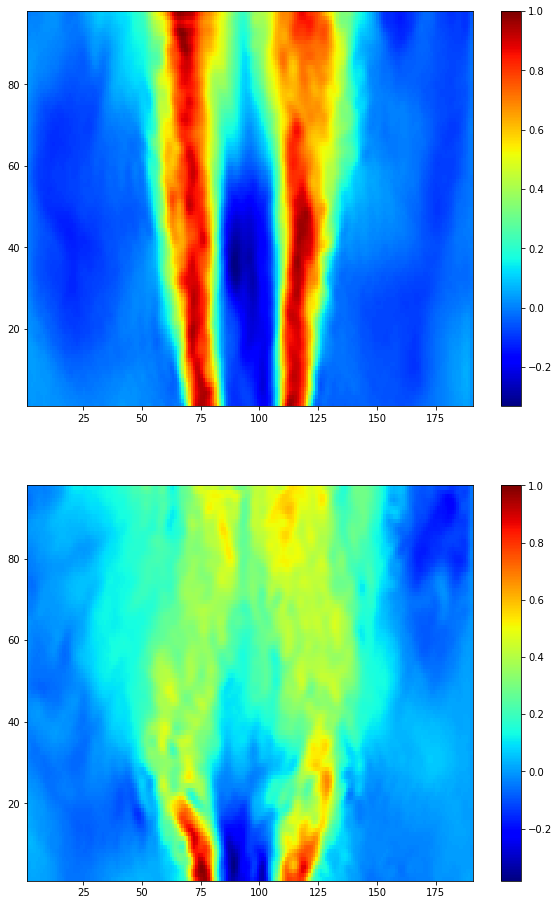

In [7]:
#データ図示
plt.figure(1, figsize=(10, 16))
plt.subplot(2,1,1)
plt.pcolor(data_cut[0],cmap='jet')
plt.colorbar()
plt.xlim(1, nx)
plt.ylim(1, ny)

plt.subplot(2,1,2)
plt.pcolor(data_cut[file_num*nz-1],cmap='jet')
plt.colorbar()
plt.xlim(1, nx)
plt.ylim(1, ny)

plt.show()

In [8]:
#target確認
print(phase_num[0:11])
print(phase_num[241:253])
print(phase_num[490])
print(phase_num[730])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


In [9]:
#データの変形
data_cut = data_cut.reshape(data_cut.shape[0],nx,ny,1)
print('data_cut shape=',data_cut.shape)

data_cut shape= (960, 191, 98, 1)


In [10]:
#学習データとtestデータに分割
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(data_cut, phase_num, test_size=test_size,random_state=1)
print(x_test.shape)
print(x_train.shape)

(96, 191, 98, 1)
(864, 191, 98, 1)


In [11]:
#機械学習モデル
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten,Conv2D, MaxPooling2D
def cnn_model():
    model=Sequential()
    model.add(Conv2D(10,kernel_size=5, padding='same', input_shape=(nx, ny, 1),activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(10,kernel_size=5, padding='same',activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dense(num_class,activation="softmax"))
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 191, 98, 10)       260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 49, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 95, 49, 10)        2510      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 24, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11280)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1443968   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5

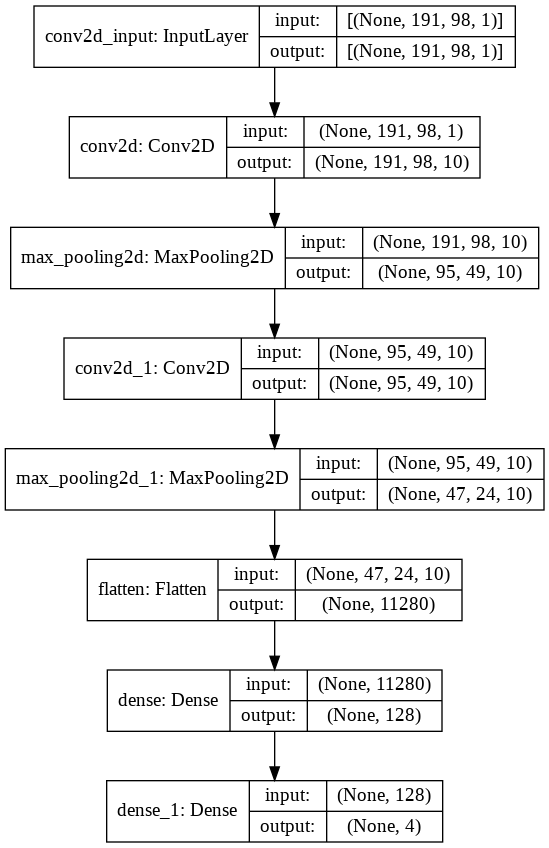

In [12]:
from tensorflow.keras.utils import plot_model
model = cnn_model()
model.summary()
#plot_model(model, to_file="modelshape_test_cnn_DNS.png",show_shapes=True)
plot_model(model,show_shapes=True)

In [13]:
# Train model
from keras import optimizers
log_name = "model_cnn_bi_DNS_2.h5"
batch_size = 1
num_epoch = 30

#cp = ModelCheckpoint(log_name, monitor="", verbose=0,
#                     save_best_only=True)

adam = optimizers.Adam(lr=0.000001)
model.compile(loss="categorical_crossentropy", optimizer=adam,metrics=['accuracy'])

        
history=model.fit(
    x_train , y_train,
    batch_size=batch_size, epochs=num_epoch,
    validation_split=0.2
    #callbacks=[cp]
      )

Epoch 1/30
691/691 [==============================] - 4s 4ms/step - loss: 1.3896 - accuracy: 0.2635 - val_loss: 1.3480 - val_accuracy: 0.3757
Epoch 2/30
691/691 [==============================] - 2s 3ms/step - loss: 1.3344 - accuracy: 0.3762 - val_loss: 1.3043 - val_accuracy: 0.7052
Epoch 3/30
691/691 [==============================] - 2s 3ms/step - loss: 1.2971 - accuracy: 0.7044 - val_loss: 1.2633 - val_accuracy: 0.6994
Epoch 4/30
691/691 [==============================] - 2s 3ms/step - loss: 1.2516 - accuracy: 0.7476 - val_loss: 1.2152 - val_accuracy: 0.7746
Epoch 5/30
691/691 [==============================] - 2s 3ms/step - loss: 1.2066 - accuracy: 0.7376 - val_loss: 1.1624 - val_accuracy: 0.8092
Epoch 6/30
691/691 [==============================] - 2s 3ms/step - loss: 1.1554 - accuracy: 0.7873 - val_loss: 1.1119 - val_accuracy: 0.8266
Epoch 7/30
691/691 [==============================] - 2s 3ms/step - loss: 1.0912 - accuracy: 0.8209 - val_loss: 1.0621 - val_accuracy: 0.8150
Epoch 

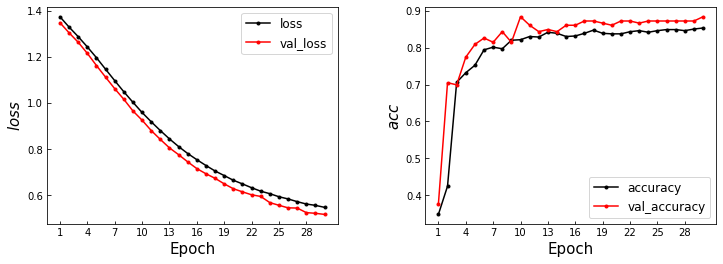

In [14]:
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
nb_epoch = len(loss)

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)
nb_epoch = len(loss)

plt.subplot(1,2,1)
plt.plot(range(1,nb_epoch+1), loss    ,color='k',marker='.', label='loss')
plt.plot(range(1,nb_epoch+1), val_loss    ,color='r',marker='.', label='val_loss')
plt.legend(loc='best', fontsize=12)
plt.xticks(np.arange(1, 30 + 1, 3))
plt.gca().yaxis.set_tick_params(which='both',direction='in')
plt.gca().xaxis.set_tick_params(direction='in')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('$loss$', fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(1,nb_epoch+1), acc,color='k',marker='.', label='accuracy')
plt.plot(range(1,nb_epoch+1), val_acc,color='r',marker='.', label='val_accuracy')
plt.legend(loc='best', fontsize=12)
plt.xticks(np.arange(1, 30 + 1, 3))
plt.gca().yaxis.set_tick_params(which='both',direction='in')
plt.gca().xaxis.set_tick_params(direction='in')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('$acc$', fontsize=15)

plt.show()
#fig.savefig("loss_cnn_bi_DNS_2.png")

In [15]:
#評価
score = model.evaluate(x_test, y_test, verbose = 1)
print('Test loss: ', score[0])
print('Tset accuracy: ', score[1])

3/3 [==============================] - 0s 6ms/step - loss: 0.4661 - accuracy: 0.9062
Test loss:  0.46608853340148926
Tset accuracy:  0.90625
